In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
%pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Dataset

In [20]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import KarateClub
import torch_geometric.datasets.karate

# dataset = Planetoid(root='.', name="Pubmed")
dataset = Planetoid(root='.', name="Cora")

# dataset= KarateClub()
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Processing...
Done!


# Mini-batching

Subgraph 0: Data(x=[200, 1433], edge_index=[2, 299], y=[200], train_mask=[200], val_mask=[200], test_mask=[200], n_id=[200], e_id=[299], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[208, 1433], edge_index=[2, 314], y=[208], train_mask=[208], val_mask=[208], test_mask=[208], n_id=[208], e_id=[314], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[250, 1433], edge_index=[2, 332], y=[250], train_mask=[250], val_mask=[250], test_mask=[250], n_id=[250], e_id=[332], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[226, 1433], edge_index=[2, 310], y=[226], train_mask=[226], val_mask=[226], test_mask=[226], n_id=[226], e_id=[310], input_id=[16], batch_size=16)
Subgraph 4: Data(x=[222, 1433], edge_index=[2, 315], y=[222], train_mask=[222], val_mask=[222], test_mask=[222], n_id=[222], e_id=[315], input_id=[16], batch_size=16)
Subgraph 5: Data(x=[250, 1433], edge_index=[2, 367], y=[250], train_mask=[250], val_mask=[250], test_mask=[250], n_id=[250], e_id=[367], input_id=[16], batch_size=16

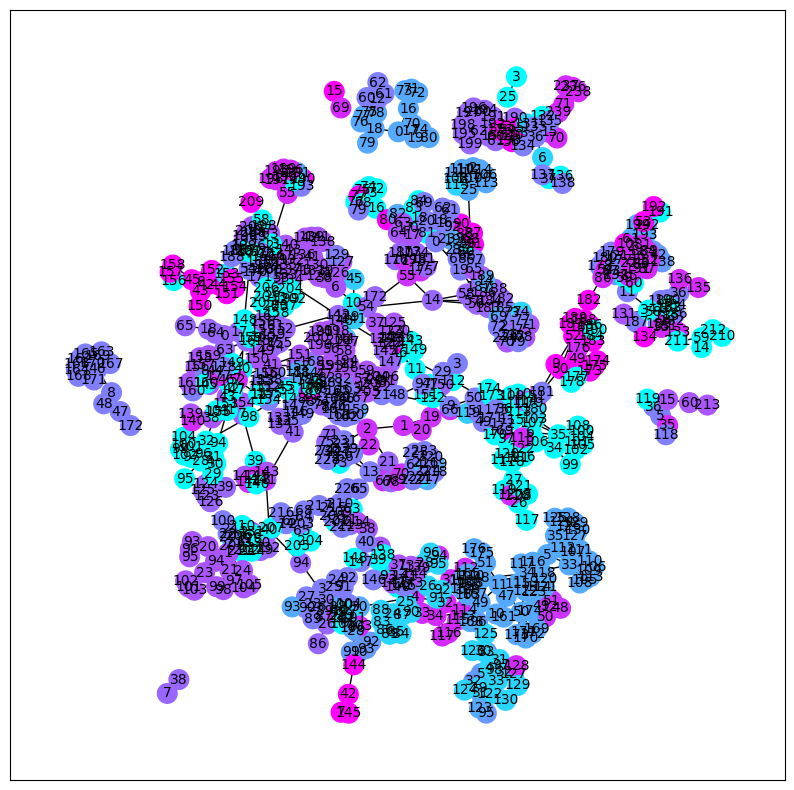

In [22]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
# fig = plt.figure(figsize=(16,16))
fig = plt.figure(figsize=(10,10))

for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    # ax = fig.add_subplot(pos)
    # ax.set_title(f'Subgraph {idx}')
    # plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

# Plot node degrees

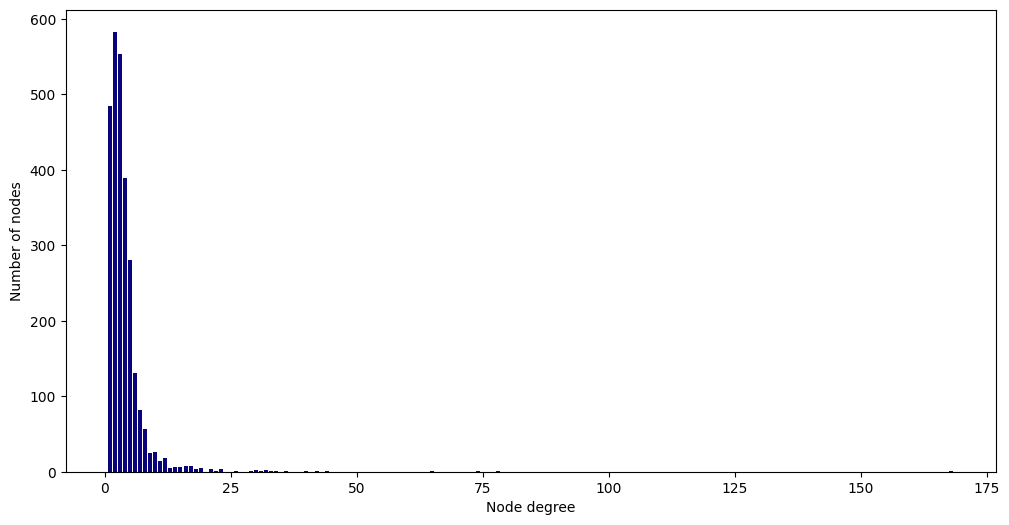

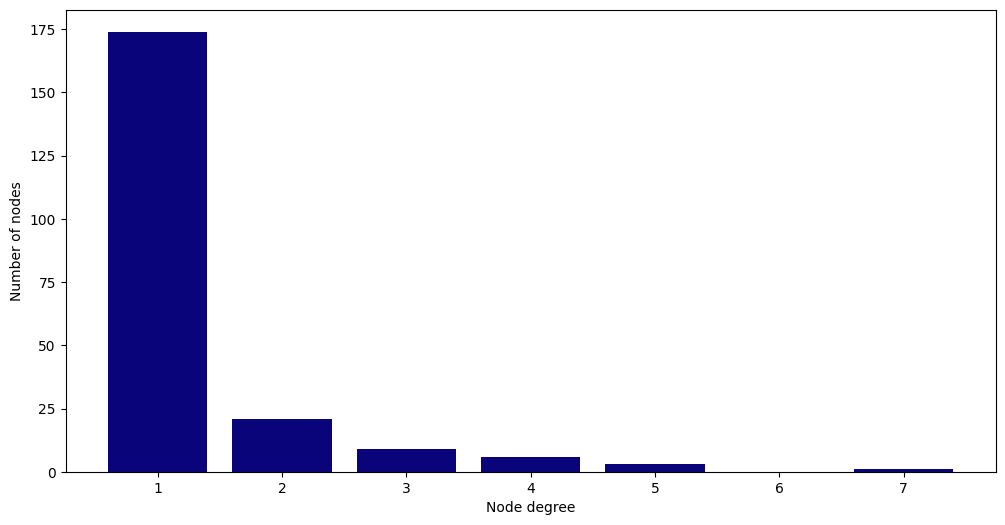

In [23]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

In [24]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')
          
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc
   

# Train GraphSAGE

In [25]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=mean)
  (sage2): SAGEConv(64, 7, aggr=mean)
)
Epoch   0 | Train Loss: 0.212 | Train Acc:  31.31% | Val Loss: 1.91 | Val Acc: 18.31%
Epoch  10 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.07 | Val Acc: 63.34%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 60.31%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 60.89%
Epoch  40 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.28 | Val Acc: 59.46%
Epoch  50 | Train Loss: 0.008 | Train Acc:  99.44% | Val Loss: 1.33 | Val Acc: 59.49%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.52 | Val Acc: 60.34%
Epoch  70 | Train Loss: 0.004 | Train Acc:  99.63% | Val Loss: 1.50 | Val Acc: 55.48%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 59.26%
Epoch  90 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.50 | Val Acc: 55.81%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.0